<span style="color:#8DB6CD; font-size:30px">**Datos de temperatura**</span>
***




<span style="color:#FFB3A7; font-size:20px">**Índice**</span>
 
- [Cargando la información del sondeo](#cargando-la-informacion-del-sondeo)
- [Procesar datos (validación)](#procesar-datos-validacion)
- [Calculo del gradiente](#calculo-del-gradiente)
- [Generar gráfico](#generar-grafico)
- [Código completo](#codigo-completo)



### <a id="cargando-la-informacion-del-sondeo"></a> <span style="color:#FFB3A7; font-size:20px"> **Cargando la información del sondeo** </span>
***

En este notebook, usaremos el archivo `Bcn_A1Almera_Temperatura.txt` que cuenta con datos de profundidad y temperatura.

Primero, importaremos las librerías:

In [18]:

import pandas as pd
from scipy.stats import linregress  # Para ajuste lineal
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, MaxNLocator
from matplotlib.lines import Line2D  # Importar Line2D para crear los elementos de la leyenda



Cargamos el archivo y creamos un DataFrame:

In [19]:
# Cargamos  datos desde el archivo TXT
data = pd.read_csv("datos_txt/R_DH02_Temperatura.txt", delim_whitespace=True, encoding="utf-8")

# Ahora puedes trabajar con el DataFrame 'data'
print(data.head()) # Muestra las primeras filas para verificar

  Depth Temperature
0     m          'C
1  0.86     16.8261
2  0.87     16.8261
3  0.88     16.8261
4  0.89     16.8222


Mostramos la información:

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13726 entries, 0 to 13725
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Depth        13726 non-null  object
 1   Temperature  13726 non-null  object
dtypes: object(2)
memory usage: 214.6+ KB


### <a id="procesar-datos-validacion"></a> <span style="color:#FFB3A7; font-size:20px"> **Procesar datos (validación)** </span>
***

Ahora procesamos los datos eliminando las unidades de cada columna y convirtiéndolos a formato numérico para que sean más fáciles de manejar.

In [21]:
data = data.iloc[1:].copy()  # Eliminar la fila de unidades en los datos de temperatura
data = data.apply(pd.to_numeric, errors='ignore')  # Convertir datos a numéricos

data.head() # Muestra las primeras filas para verificar

,Depth,Temperature
1,0.86,16.8261
2,0.87,16.8261
3,0.88,16.8261
4,0.89,16.8222
5,0.90,16.8222


In [22]:
#verificamos que el tipo de dato sea numéricos.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13725 entries, 1 to 13725
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Depth        13725 non-null  float64
 1   Temperature  13725 non-null  float64
dtypes: float64(2)
memory usage: 214.6 KB


### <a id="calculo-del-gradiente"></a> <span style="color:#FFB3A7; font-size:20px"> **Calculo del gradiente** </span>
***

A continuación, calcularemos el gradiente de temperatura en el agua utilizando la regresión lineal (`water_Gadient`).
La pendiente de la recta ajustada representará el cambio medio de temperatura con respecto a la profundidad a lo largo de todo el rango de datos en el agua. 


In [23]:
# Definir la profundidad de la linea del agua
profundidad_agua = 31.3 #metros

# Filtrar datos desde la profundidad de la linea del agua en adelante
df_filtrado = data[data["Depth"] >= profundidad_agua].copy()

# Ajustar regresión lineal (Temperatura vs Profundidad)
slope, intercept, r_value, p_value, std_err = linregress(df_filtrado["Depth"], df_filtrado["Temperature"])

# Convertir el gradiente de °C/m a °C/Km
water_gradient = slope * 1000  # Convertir a °C/Km

# Mostrar resultado
print(f"Gradiente térmico medio del agua: {water_gradient:.0f} °C/Km (basado en regresión lineal)")
print(f"Coeficiente de correlación R²: {r_value**2:.2f}")  # Indica qué tan bien se ajusta la línea


Gradiente térmico medio del agua: 22 °C/Km (basado en regresión lineal)
Coeficiente de correlación R²: 0.00


En este paso, creamos una nueva columna en el DataFrame para calcular el gradiente térmico en cada intervalo de 0.05 metros. El gradiente se calcula como la **diferencia de temperaturas** entre dos puntos consecutivos dividida por la **diferencia de profundidades** entre esos mismos puntos. 
Debido a que no hay un punto anterior para el primer valor, el cálculo del gradiente para la primera fila es NaN (no disponible).


In [24]:
# Crear columna de gradiente térmico (NaN en la primera fila porque no tiene diferencia)
data["Gradient"] = (data["Temperature"].diff() / 0.05) * 1000 #en Km
data

,Depth,Temperature,Gradient
1,0.86,16.8261,NaN
2,0.87,16.8261,0.0
3,0.88,16.8261,0.0
4,0.89,16.8222,-78.0
5,0.90,16.8222,0.0
...,...,...,...
13721,138.06,21.4366,0.0
13722,138.07,21.4366,0.0
13723,138.08,21.4287,-158.0
13724,138.09,21.4326,78.0


In [25]:
# **Eliminar valores negativos e interpolar**
data.loc[data["Temperature"] < 0, "Temperature"] = None  # Reemplazar negativos con NaN
data["Temperature"] = data["Temperature"].interpolate(method='linear')  # Interpolación lineal


### <a id="generar-grafico"></a> <span style="color:#FFB3A7; font-size:20px"> **Generar Gráfico** </span>
***



In [26]:
# Filtrar datos para el agua (profundidades mayores o iguales a 31.3 m)
#df_agua = data[data["Depth"] >= profundidad_agua].copy()

# Filtrar datos para el aire (profundidades menores a 31.3 m)
#df_aire = data[data["Depth"] < profundidad_agua].copy()



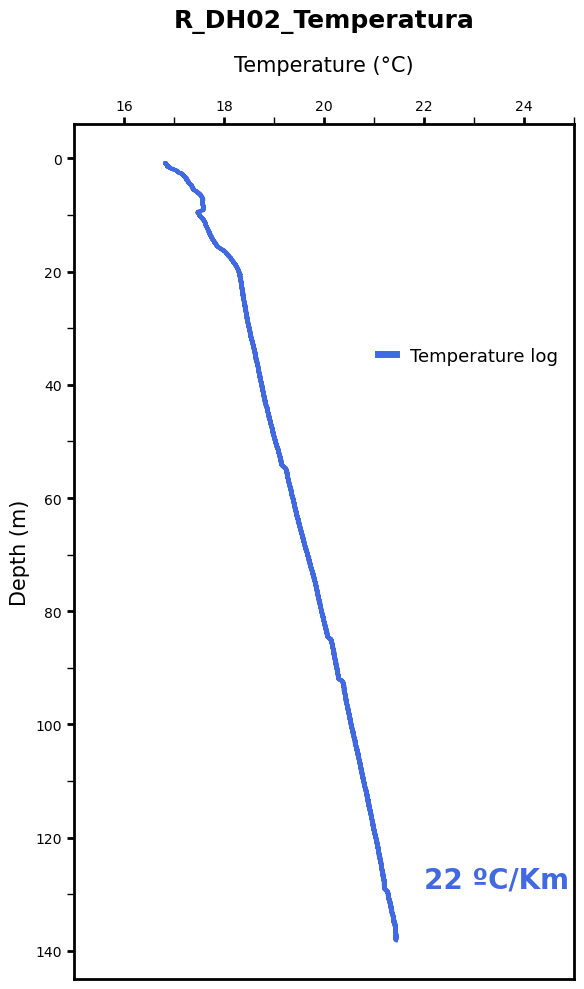

In [30]:

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(6, 10))

# Graficar la curva 

ax.plot(data["Temperature"], data["Depth"], 
                       color='royalblue', linewidth=3, label='Water temperature log')

# Configuración de los ejes
ax.set_xlabel('Temperature (°C)', fontsize=15, labelpad=20)  # Aumenta separación con labelpad
ax.set_ylabel('Depth (m)', fontsize=15)

ax.set_xlim(15, 25)  # Rango de temperatura
ax.invert_yaxis()  # Invertir eje Y para que 0m esté arriba

# Configuración del eje x y y
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
ax.xaxis.set_major_locator(MultipleLocator(2))  
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Hacer más grueso y largo los ticks
ax.tick_params(axis='both', which='major', width=2, length=5, labelsize=10)  # Ticks principales
ax.tick_params(axis='both', which='minor', width=1, length=5)  # Ticks menores

# Hacer más grueso el borde del gráfico
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Grosor del marco del gráfico 2 pixeles

# Agregar título
ax.set_title('R_DH02_Temperatura', fontsize=18, fontweight='bold', pad=20)

# Definir los elementos de la leyenda con líneas personalizadas
legend_elements = [
    Line2D([0], [0], color='royalblue', lw=5, label='Temperature log')  # Línea más gruesa
]

# Crear la leyenda usando los elementos personalizados
legend = ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0.7), fontsize=13, handlelength=1)

legend.get_frame().set_linewidth(0)  # Eliminar el contorno de la leyenda

# Agregar el texto con el gradiente en agua
ax.text(0.7, 0.1, f'{water_gradient:.0f} ºC/Km', 
        transform=ax.transAxes, fontsize=20, color='royalblue', 
        verticalalignment='bottom', horizontalalignment='left', fontweight='bold')

# Ajustar el diseño para que no se solapen los elementos
plt.tight_layout()

# Exportar la figura como PNG y PDF
plt.savefig(f"datos_png_pdf/R_DH02_Temperatura.png", dpi=300)
plt.savefig(f"datos_png_pdf/R_DH02_Temperatura.pdf", format='pdf')
plt.show()


Perfil con las Curvas de Temperatura y Gradiente de Temperatura 

NameError: name 'df_aire' is not defined

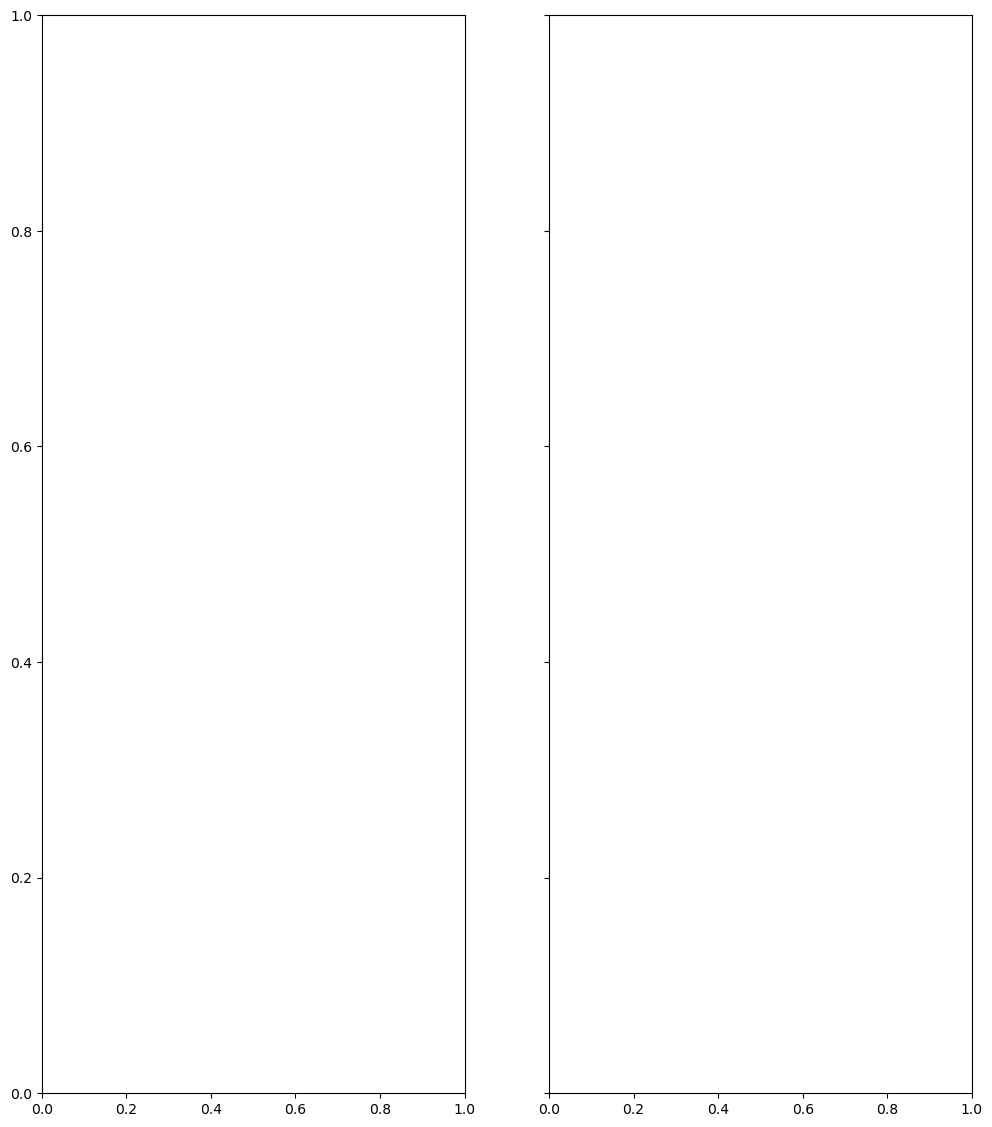

In [28]:

# Crear la figura y los subgráficos (2 en una fila)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 14), sharey=True)

# Primer subgráfico para la curva de temperatura
axs[0].plot(df_aire["Temperature"], df_aire["Depth"], color='#D08F8F', linewidth=3, label='Air temperature log')
axs[0].plot(df_agua["Temperature"], df_agua["Depth"], color='royalblue', linewidth=3, label='Water temperature log')

# Configuración del primer subgráfico (Temperatura)
axs[0].set_xlabel('Temperature (°C)', fontsize=15, labelpad=10)
axs[0].set_ylabel('Depth (m)', fontsize=15)
axs[0].invert_yaxis()  # Invertir el eje Y para que 0m esté arriba
axs[0].set_title('Temperature Profile', fontsize=18, fontweight='bold', pad=20)

# Definir los elementos de la leyenda con líneas personalizadas
legend_elements = [
    Line2D([0], [0], color='#D08F8F', lw=5, label='Air temperature log'),  # Línea más gruesa
    Line2D([0], [0], color='royalblue', lw=5, label='Water temperature log')  # Línea más gruesa
]

# Añadir la leyenda al primer gráfico
axs[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.01, 0.97), fontsize=13, handlelength=1, frameon=False)

axs[0].tick_params(axis='both', which='major', width=2, length=5, labelsize=12)
axs[0].tick_params(axis='both', which='minor', width=1, length=5)
axs[0].yaxis.set_major_locator(MultipleLocator(20))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))

# Añadir el gradiente medio en el gráfico de temperatura
axs[0].text(0.5, 0.1, f'{water_gradient:.0f} °C/Km', transform=axs[0].transAxes, 
            fontsize=17, color='royalblue', ha='left', va='bottom', fontweight='bold')

# Suavizar el gradiente con un filtro de media móvil de 50 metros
gradiente_suavizado = data["Gradient"].rolling(window=50).mean()

# Segundo subgráfico para el gradiente de temperatura
axs[1].plot(gradiente_suavizado, data["Depth"], color='darkorchid', lw=3, label='Gradient 50m (smoothed)')

# Configuración del segundo subgráfico (Gradiente)
axs[1].set_xlabel('Temperature Gradient (°C/Km)', fontsize=15, labelpad=10)
axs[1].set_xlim(0, 70)  # Limitar el rango del eje X de gradiente
axs[1].set_title('Temperature Gradient Profile', fontsize=18, fontweight='bold', pad=20)

# Añadir la leyenda al segundo gráfico
axs[1].legend(handles=[Line2D([0], [0], color='darkorchid', lw=5, label='Gradient 50m (smoothed)')], 
              loc='upper center', bbox_to_anchor=(0.3, 0.97), fontsize=13, handlelength=1, frameon=False)


axs[1].tick_params(axis='both', which='major', width=2, length=5, labelsize=12)
axs[1].tick_params(axis='both', which='minor', width=1, length=5)
axs[1].yaxis.set_major_locator(MultipleLocator(20))
axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))

# Eliminar la etiqueta de profundidad en el gráfico del gradiente
axs[1].set_ylabel('')  # Eliminar el ylabel (profundidad)


# Mover el eje X a la parte superior para ambos gráficos
for ax in axs:
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

# Añadir un título conjunto para ambos gráficos
fig.suptitle('A1 Almera', fontsize=20, fontweight='bold', y=0.98)

# Ajustar el diseño para que no se solapen los elementos
plt.tight_layout(pad=3.0)

# Guardar la figura como PNG y PDF
plt.savefig(f"datos_png_pdf/A1Almera_Temperatura_Gradiente.png", dpi=300)
plt.savefig(f"datos_png_pdf/A1Almera_Temperatura_Gradiente.pdf", format='pdf')

plt.show()


### <a id="codigo-completo"></a> <span style="color:#FFB3A7; font-size:20px"> **Código completo** </span>
***

Codigo completo de la curva de temperatura mostrado paso a paso en este notebook: 

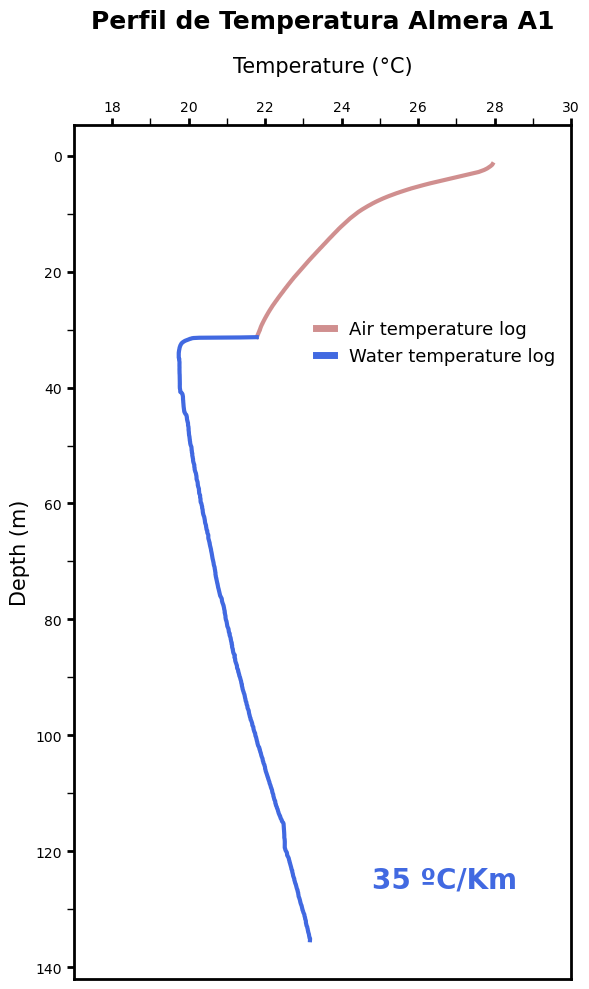

In [ ]:
import pandas as pd
from scipy.stats import linregress  # Para ajuste lineal
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, MaxNLocator
from matplotlib.lines import Line2D  # Importar Line2D para crear los elementos de la leyenda


# Cargar datos desde el archivo TXT
data = pd.read_csv("datos_txt/Bcn_A1Almera_Temperatura.txt", delim_whitespace=True, encoding="utf-8")

# Eliminar la fila de unidades en los datos de temperatura
data = data.iloc[1:].copy()  

# Convertir datos a numéricos
data = data.apply(pd.to_numeric, errors='coerce')

# Definir la profundidad mínima del agua
profundidad_agua = 31.3

# Filtrar datos desde la profundidad de 24.23 metros en adelante
df_filtrado = data[data["Depth"] >= profundidad_agua].copy()

# Calculamos el gradiente medio en agua
# Ajustar regresión lineal (Temperatura vs Profundidad)
slope, intercept, r_value, p_value, std_err = linregress(df_filtrado["Depth"], df_filtrado["Temperature"])

# Convertir el gradiente de °C/m a °C/Km
water_gradient = slope * 1000  # Convertir a °C/Km

# Calculamos el gradiente para cada profundidad en el sondeo
# Crear columna de gradiente térmico (NaN en la primera fila porque no tiene diferencia)
data["Gradient"] = (data["Temperature"].diff() / 0.05) * 1000 #en Km

# Filtrar datos para el agua (profundidades mayores o iguales a 31.3 m)
df_agua = data[data["Depth"] >= profundidad_agua].copy()

# Filtrar datos para el aire (profundidades menores a 31.3 m)
df_aire = data[data["Depth"] < profundidad_agua].copy()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(6, 10))

# Graficar la curva 
df_agua = data[data["Depth"] >= profundidad_agua].copy()
df_aire = data[data["Depth"] < profundidad_agua].copy()

ax.plot(df_aire["Temperature"], df_aire["Depth"], 
                       color='#D08F8F', linewidth=3, label='Air temperature log')

ax.plot(df_agua["Temperature"], df_agua["Depth"], 
                       color='royalblue', linewidth=3, label='Water temperature log')

# Configuración de los ejes
ax.set_xlabel('Temperature (°C)', fontsize=15, labelpad=20)  # Aumenta separación con labelpad
ax.set_ylabel('Depth (m)', fontsize=15)

ax.set_xlim(17, 30)  # Rango de temperatura
ax.invert_yaxis()  # Invertir eje Y para que 0m esté arriba


# Configuración del eje x y y
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  
ax.xaxis.set_major_locator(MultipleLocator(2))  
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Hacer más grueso y largo los ticks
ax.tick_params(axis='both', which='major', width=2, length=5, labelsize=10)  # Ticks principales
ax.tick_params(axis='both', which='minor', width=1, length=5)  # Ticks menores

# Hacer más grueso el borde del gráfico
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Grosor del marco del gráfico

# Agregar título
ax.set_title('Perfil de Temperatura Almera A1', fontsize=18, fontweight='bold', pad=20)

# Definir los elementos de la leyenda con líneas personalizadas
legend_elements = [
    Line2D([0], [0], color='#D08F8F', lw=5, label='Air temperature log'),  # Línea más gruesa
    Line2D([0], [0], color='royalblue', lw=5, label='Water temperature log')  # Línea más gruesa
]

# Crear la leyenda usando los elementos personalizados
legend = ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0.7), fontsize=13, handlelength=1)

legend.get_frame().set_linewidth(0)  # Eliminar el contorno de la leyenda

# Agregar el texto con el gradiente en agua
ax.text(0.6, 0.1, f'{water_gradient:.0f} ºC/Km', 
        transform=ax.transAxes, fontsize=20, color='royalblue', 
        verticalalignment='bottom', horizontalalignment='left', fontweight='bold')

plt.tight_layout()

# Exportar la figura como PNG y PDF
plt.savefig(f"datos_png_pdf/A1Almera_Temperatura.png", dpi=300)
plt.savefig(f"datos_png_pdf/A1Almera_Temperatura.pdf", format='pdf')
plt.show()